# Original PanAns Comparison

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [5]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33139/status,
Dashboard: /proxy/33139/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35729,Workers: 0
Dashboard: /proxy/33139/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44643,Total threads: 1
Dashboard: /proxy/45207/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35643,


## Importing the data

In [6]:
save_dir = '/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/'

runoff_pert_pan = xr.open_dataarray(save_dir + 'runoff_pert_prescribed_pan01.nc')
runoff_minus_restoring_change_pan = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_prescribed_pan01.nc')
restoring_change_pan = xr.open_dataarray(save_dir + 'restoring_change_prescribed_pan01.nc')

runoff_pert_acc = xr.open_dataarray(save_dir + 'runoff_pert_prescribed_access.nc')
runoff_minus_restoring_change_acc = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_prescribed_access.nc')
restoring_change_acc = xr.open_dataarray(save_dir + 'restoring_change_prescribed_access.nc')

In [7]:
runoff_pert_pan = runoff_pert_pan.to_series()
runoff_minus_restoring_change_pan = runoff_minus_restoring_change_pan.to_series()
restoring_change_pan = restoring_change_pan.to_series()

runoff_pert_acc = runoff_pert_acc.to_series()
runoff_minus_restoring_change_acc = runoff_minus_restoring_change_acc.to_series()
restoring_change_acc = restoring_change_acc.to_series()

## Plotting

In [8]:
import matplotlib.lines as mlines
import matplotlib.dates as mdates

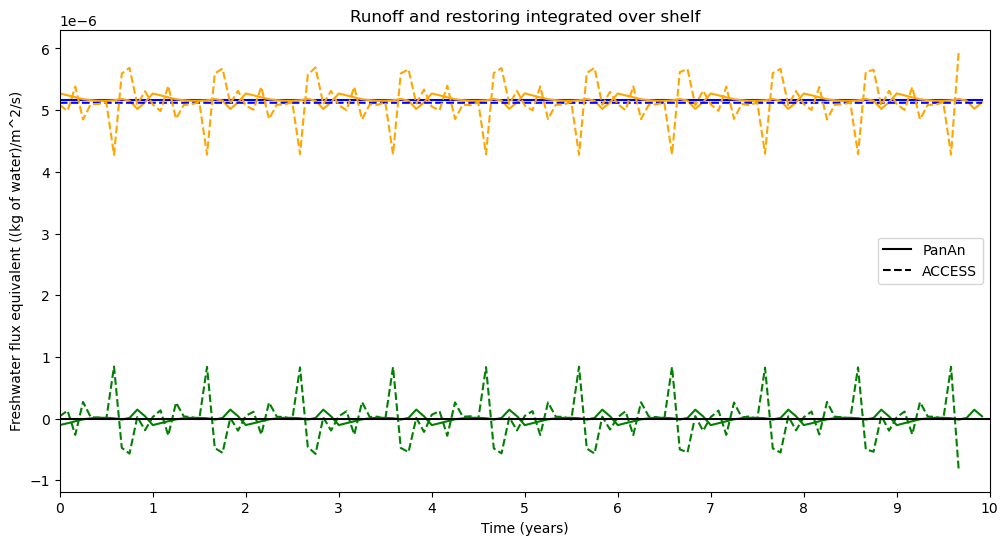

In [9]:
plt.figure(figsize=(12, 6))

# Plot 1/10th degree
runoff_pert_pan.plot(label='runoff perturbation PanAn', color='b')
runoff_minus_restoring_change_pan.plot(label='runoff minus restoring change 1/10th', color='orange')
restoring_change_pan.plot(label='restoring change 1/10th', color='g')

# Plot 1/20th degree
runoff_pert_acc.plot(label='runoff perturbation ACCESS', color='b', linestyle='--')
runoff_minus_restoring_change_acc.plot(label='runoff minus restoring change ACCESS', color='orange', linestyle='--')
restoring_change_acc.plot(label='restoring change ACCESS', color='g', linestyle='--')

# Custom legend (solid = 1/10°, dashed = 1/20°)
line_10 = mlines.Line2D([], [], color='black', linestyle='-', label='PanAn')
line_20 = mlines.Line2D([], [], color='black', linestyle='--', label='ACCESS')
plt.legend(handles=[line_10, line_20], loc='center right')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

plt.axhline(y=0, color='black', linestyle='-')
plt.xlim(0,120)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')

plt.show()


In [10]:
# Apply 12-month running mean (pandas)
rp_pan = runoff_pert_pan.rolling(window=12, center=True).mean()
rmr_pan = runoff_minus_restoring_change_pan.rolling(window=12, center=True).mean()
rc_pan = restoring_change_pan.rolling(window=12, center=True).mean()

rp_acc = runoff_pert_acc.rolling(window=12, center=True).mean()
rmr_acc = runoff_minus_restoring_change_acc.rolling(window=12, center=True).mean()
rc_acc = restoring_change_acc.rolling(window=12, center=True).mean()

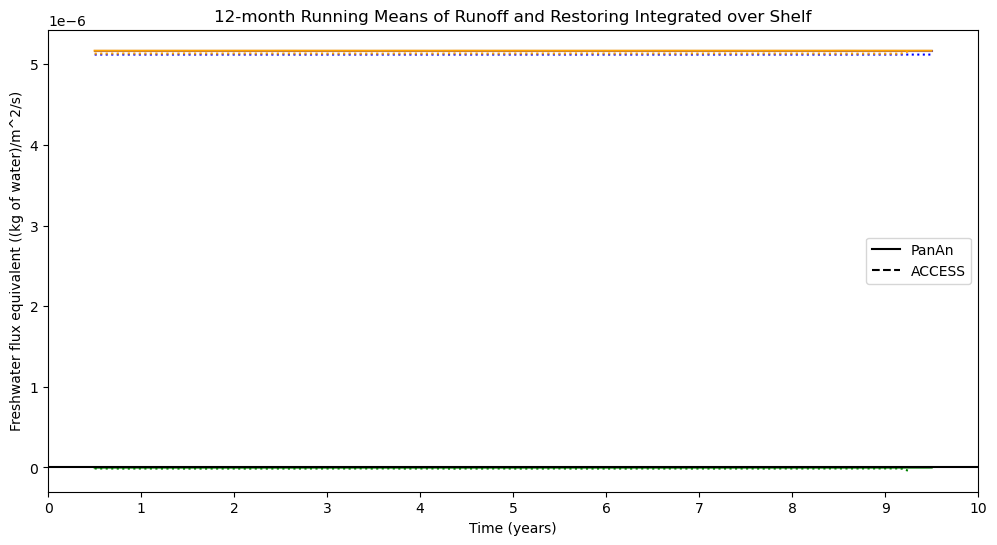

In [11]:
plt.figure(figsize=(12, 6))

# Plot 1/10th degree
rp_pan.plot(label='runoff perturbation PanAn', color='b')
rmr_pan.plot(label='runoff minus restoring change PanAn', color='orange')
rc_pan.plot(label='restoring change PanAn', color='g')

# Plot ACCESS
rp_acc.plot(label='runoff perturbation ACCESS', color='b', linestyle=':')
rmr_acc.plot(label='runoff minus restoring change ACCESS', color='orange', linestyle=':')
rc_acc.plot(label='restoring change ACCESS', color='g', linestyle=':')

# Custom legend (solid = 1/10°, dashed = 1/20°, dotted = ACCESS)
line_10 = mlines.Line2D([], [], color='black', linestyle='-', label='PanAn')
line_ACC = mlines.Line2D([], [], color='black', linestyle='--', label='ACCESS')
plt.legend(handles=[line_10, line_ACC], loc='center right')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

plt.axhline(y=0, color='black', linestyle='-')
plt.xlim(0, 120)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('12-month Running Means of Runoff and Restoring Integrated over Shelf')

plt.show()


### Converting to Sv

Step 1: Recognize the conversion

kg/m²/s → m/s of water:
For freshwater, density ≈ 1000 kg/m³, so

$$ \text{velocity equivalent (m/s)} = \frac{flux (kg/m²/s)}{1000 kg/m³} $$

Multiply by area to get volume flux (m³/s). If your flux is integrated over the shelf area, then

$$ \text{volume flux (m³/s)} = \frac{flux (kg/m²/s)}{1000} × area (m²) $$

Convert to Sv: $ 1 Sv = 10^{6} m³/s $, so divide by $10^{6}$.

**First I'm finding the shelf area sum for each model:**

The method below is really clunky, don't mind that

In [12]:
## ACCESS shelf mask
# shelf masking:
contour_file_acc = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask_acc = contour_file_acc['contour_masked_above']
yt_ocean = contour_file_acc['yt_ocean'] #slice to match lat_slice
xt_ocean = contour_file_acc['xt_ocean']
# Mask values that are non-zero
shelf_mask_acc[np.where(shelf_mask_acc!=0)] = np.nan
shelf_mask_acc = shelf_mask_acc+1
shelf_mask_acc = xr.DataArray(shelf_mask_acc, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

## Pan01 shelf mask
# shelf masking:
contour_file_01 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')
shelf_mask_01 = contour_file_01['contour_masked_above'].to_numpy()
yh_01 = contour_file_01['yh'] #slice to match lat_slice
xh_01 = contour_file_01['xh']
# Mask values that are non-zero
shelf_mask_01[np.where(shelf_mask_01!=0)] = np.nan
shelf_mask_01 = shelf_mask_01+1
shelf_mask_01 = xr.DataArray(shelf_mask_01, coords = [('yh', yh_01.values), ('xh', xh_01.values)])

In [13]:
shelf_mask_acc

<xarray.DataArray (yt_ocean: 510, xt_ocean: 3600)> Size: 7MB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

In [14]:
# ACCESS shelf area
acc_area_old = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean_grid.nc')['area_t']
acc_var = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean.nc')['salt'].isel(time=0,st_ocean=0)

In [15]:
acc_area_corr = acc_area_old*(acc_var*0 +1)

In [16]:
acc_area = (acc_area_corr*shelf_mask_acc)
acc_area_sum = acc_area.sum(dim={'xt_ocean','yt_ocean'})

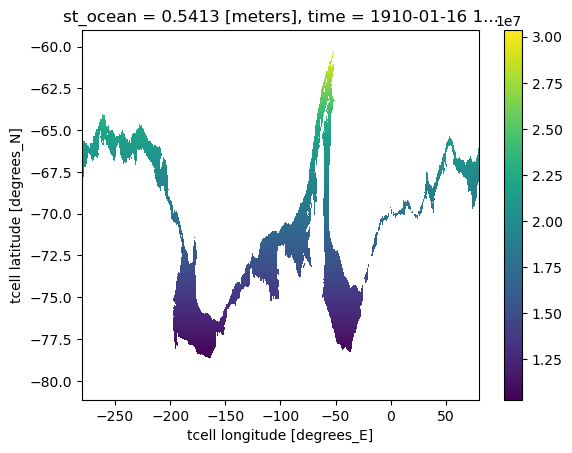

In [17]:
acc_area.plot()

In [18]:
# Pan01 shelf area
pan01_area_old = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
pan01_var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(time=0,z_l=0)
pan01_area_corr = pan01_area_old*(pan01_var*0 +1)
pan01_area = (pan01_area_corr*shelf_mask_01).load()
pan01_area_sum = pan01_area.sum(dim={'xh','yh'}).load()

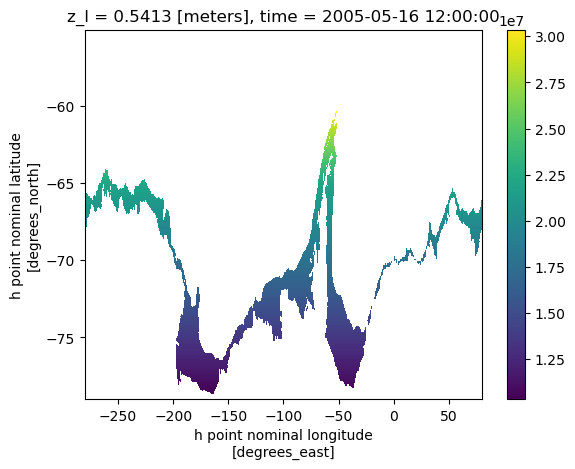

In [19]:
pan01_area.plot()

In [20]:
pan01_area_sum

<xarray.DataArray ()> Size: 4B
array(2.864998e+12, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

**Now using shelf sum to convert to Sv**:

In [21]:
# Convert already-integrated fluxes to Sv
rp_pan_Sv  = rp_pan  * pan01_area_sum.values / 1000 / 1e6
rmr_pan_Sv = rmr_pan * pan01_area_sum.values / 1000 / 1e6
rc_pan_Sv  = rc_pan  * pan01_area_sum.values / 1000 / 1e6

rpacc_Sv  = rp_acc  * acc_area_sum.values / 1000 / 1e6
rmracc_Sv = rmr_acc * acc_area_sum.values / 1000 / 1e6
rcacc_Sv  = rc_acc  * acc_area_sum.values / 1000 / 1e6

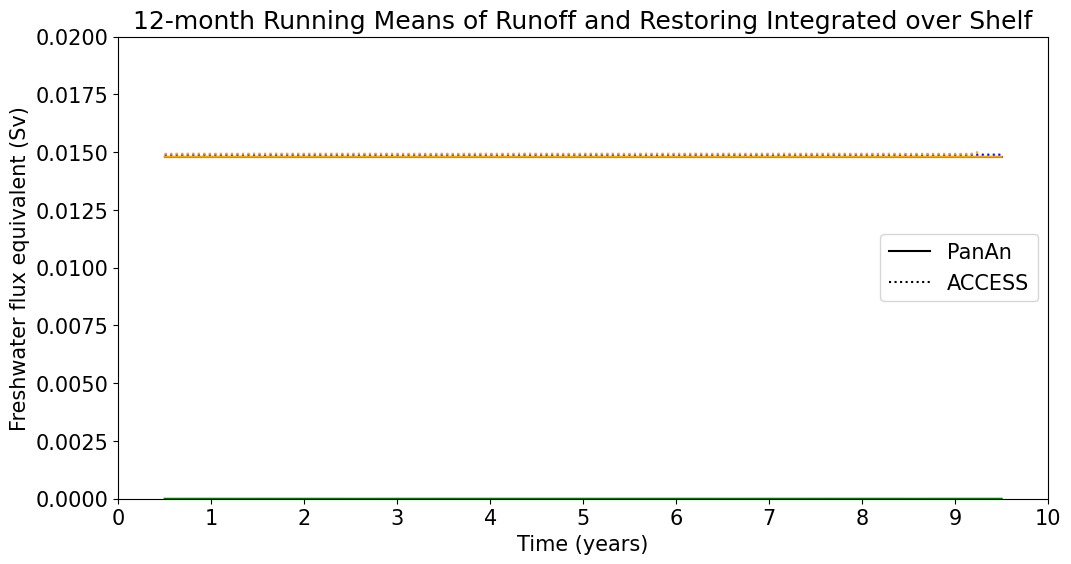

In [22]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(12, 6))

# 1/10th degree PanAn
rp_pan_Sv.plot(label='runoff perturbation 1/10th', color='b')
rmr_pan_Sv.plot(label='runoff minus restoring change 1/10th', color='orange')
rc_pan_Sv.plot(label='restoring change 1/10th', color='g')

# ACCESS
rpacc_Sv.plot(label='runoff perturbation ACCESS', color='b', linestyle=':')
rmracc_Sv.plot(label='runoff minus restoring change ACCESS', color='orange', linestyle=':')
rcacc_Sv.plot(label='restoring change ACCESS', color='g', linestyle=':')

# Custom legend
line_Pan = mlines.Line2D([], [], color='black', linestyle='-', label='PanAn')
line_ACC = mlines.Line2D([], [], color='black', linestyle=':', label='ACCESS')
plt.legend(handles=[line_Pan, line_ACC], loc='center right')

# X-axis ticks in years
ticks = range(0, 121, 12)
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)
plt.xlim(0, 120)
plt.ylim(0,0.02)

plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent (Sv)')
plt.title('12-month Running Means of Runoff and Restoring Integrated over Shelf')

plt.show()

In [23]:
rpacc_Sv[10]

0.014895040779705049

### Bar plot

In [24]:
runoff_pert_pan_Sv = runoff_pert_pan * pan01_area_sum.values / 1000 / 1e6
runoff_minus_restoring_change_pan_Sv = runoff_minus_restoring_change_pan * pan01_area_sum.values / 1000 / 1e6
restoring_change_pan_Sv = restoring_change_pan * pan01_area_sum.values / 1000 / 1e6

runoff_pert_acc_Sv = runoff_pert_acc * acc_area_sum.values / 1000 / 1e6
runoff_minus_restoring_change_acc_Sv = runoff_minus_restoring_change_acc * acc_area_sum.values / 1000 / 1e6
restoring_change_acc_Sv = restoring_change_acc * acc_area_sum.values / 1000 / 1e6

In [25]:
# Convert already-integrated fluxes to Sv
rp_pan_Sv  = rp_pan  * pan01_area_sum.values / 1000 / 1e6
rmr_pan_Sv = rmr_pan * pan01_area_sum.values / 1000 / 1e6
rc_pan_Sv  = rc_pan  * pan01_area_sum.values / 1000 / 1e6

rpacc_Sv  = rp_acc  * acc_area_sum.values / 1000 / 1e6
rmracc_Sv = rmr_acc * acc_area_sum.values / 1000 / 1e6
rcacc_Sv  = rc_acc  * acc_area_sum.values / 1000 / 1e6

In [26]:
# Define number of months for the last 5 years
last_5yrs = 5 * 12  # 60 months

# Compute mean of last 5 years
means = {
    'runoff_pert_pan': runoff_pert_pan_Sv[-last_5yrs:].mean(),
    'runoff_minus_restoring_change_pan': runoff_minus_restoring_change_pan_Sv[-last_5yrs:].mean(),
    'restoring_change_pan': restoring_change_pan_Sv[-last_5yrs:].mean(),
    'runoff_pert_acc': runoff_pert_acc_Sv[-last_5yrs:].mean(),
    'runoff_minus_restoring_change_acc': runoff_minus_restoring_change_acc_Sv[-last_5yrs:].mean(),
    'restoring_change_acc': restoring_change_acc_Sv[-last_5yrs:].mean()
}

In [34]:
colors = {'pan01_res': '#0000a2',
          'pan005_res': '#E84141',
          'pan01_pre' : '#18669C',
          'access_pre': 'tab:orange'}

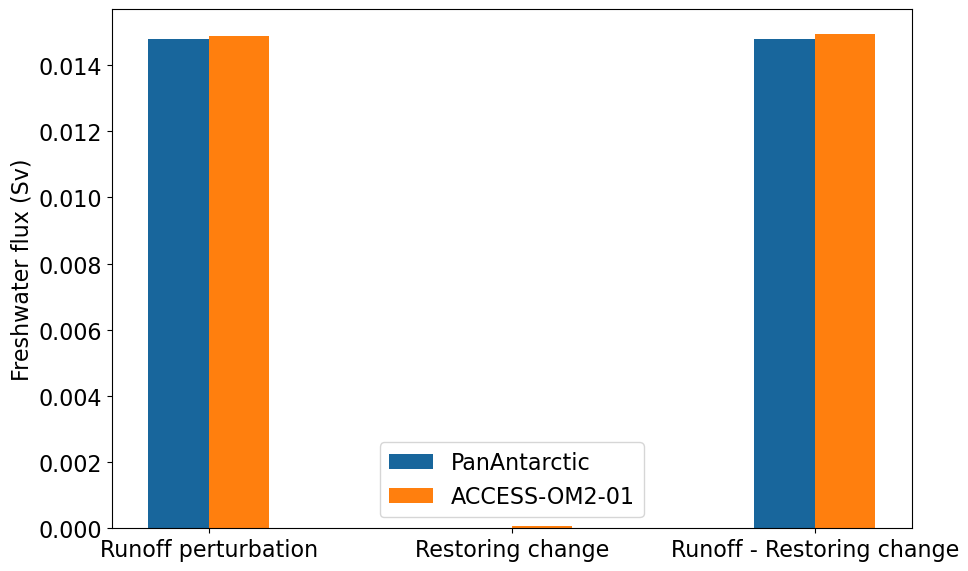

In [35]:
plt.rcParams['font.size'] = 16

# Define groups and values
processes = ['Runoff perturbation', 'Restoring change','Runoff - Restoring change']

# Order: 1/10°, 1/20°, ACCESS
values_grouped = [
    [means['runoff_pert_pan'], means['runoff_pert_acc']],
    [-means['restoring_change_pan'], -means['restoring_change_acc']],
    [means['runoff_minus_restoring_change_pan'], means['runoff_minus_restoring_change_acc']]
    
]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(processes))  # the label locations

plt.figure(figsize=(10,6))

# Plot each resolution as a separate set
plt.bar(x - 0.5*bar_width, [v[0] for v in values_grouped], width=bar_width, color=colors['pan01_pre'], label='PanAntarctic')
plt.bar(x + 0.5*bar_width, [v[1] for v in values_grouped], width=bar_width, color=colors['access_pre'], label='ACCESS-OM2-01')

# Labels and formatting
plt.axhline(y=0, color='black', linestyle='-',linewidth = 0.5)
plt.xticks(x, processes)
plt.ylabel('Freshwater flux (Sv)')
#plt.title('Runoff and restoring integrated over shelf')
plt.legend()
plt.tight_layout()
plt.savefig("/g/data/g40/kc5856/thesis_figures/Method_Prescribed_RestoreBars_new.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
means['runoff_minus_restoring_change_pan']

0.01480271596446924

In [30]:
means['runoff_minus_restoring_change_acc']

0.014949751626140493

In [31]:
means['runoff_pert_pan']

0.0148002235

In [32]:
means['runoff_pert_acc']

0.014895041